In [26]:
del model

In [1]:
# -*- coding: utf-8 -*-


#==============================================================================
# # # Module
#==============================================================================

from __future__ import print_function


import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import subprocess
import os
import pickle
import sklearn 

from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier




import keras.backend as K

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121, DenseNet201, preprocess_input
#from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile,NASNetLarge

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img



from keras.applications.xception import Xception, preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Input, Conv2D, MaxPooling2D, merge, Lambda,UpSampling2D, concatenate, Reshape, Dropout,Cropping2D,Activation
from keras.models import Model, load_model
import pandas as pd

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import Callback

from sklearn.metrics import accuracy_score
from keras import regularizers
#from dummyPy import OneHotEncoder
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

import itertools
import time

import gc




#os.chdir(r'.....\SDP_code\resnet') ##
#os.chdir(r'resnet') ##
import resnet
from resnet import basic_block

#==============================================================================
# # # Initial setting
#==============================================================================

Using TensorFlow backend.


In [2]:
import gc
gc.collect()

7

In [40]:

train_read_path = r'./dataset3/train/' ##
val_read_path = r'./dataset3/validation/' ##

#h_size,w_size= 384,512
size, channel = (224,224), 3

num_classes = 2
block_par = [3, 4, 6, 3]

batch = 32


save_dir =  './np_data_model/'


In [41]:

#==============================================================================
# # # Train - Generator
#==============================================================================
'''
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=[0.9, 1.1], 
        fill_mode = 'reflect')
'''

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zca_whitening = True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    directory=train_read_path,
    target_size=size,
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


valid_datagen = ImageDataGenerator(
        rescale=1./255)



valid_generator = valid_datagen.flow_from_directory(
    directory=val_read_path,
    target_size=size,
    color_mode="rgb",
    batch_size=65,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py:787: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1941 images belonging to 2 classes.
Found 1878 images belonging to 2 classes.


In [42]:


def build_model_2():
    inputs = Input(shape=(224,224,3))
    #inputs = Lambda(lambda x: x/275. - 1.0)(inputs)
    # create the base pre-trained model

    base_model =DenseNet121(weights='imagenet',input_tensor=inputs,  include_top=True)

    x = base_model.layers[-2].output

    x = Dense(128,activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(32,activation='relu')(x)
    x = Dropout(0.3)(x)

    output = Dense(2,activation = 'softmax')(x)


    model = Model(inputs=base_model.input, outputs=output)
    model.summary()

    return model

In [43]:

#==============================================================================
# # # Train - Fit - ResNet
#==============================================================================

model = build_model_2()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [44]:
#model = load_model 

In [62]:
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [63]:


Step_Train = train_generator.n//train_generator.batch_size

print (train_generator.n, train_generator.batch_size)
Step_Valid = valid_generator.n

#define callback


#define callback
model_save_loss = save_dir+'Stage_1_DenseNet121_binary_generator_1_loss.h5'
model_save_acc = save_dir+'Stage_1_DenseNet121_binary_generator_1_acc.h5'
checkpoint_loss = ModelCheckpoint(model_save_loss, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint_acc = ModelCheckpoint(model_save_acc, monitor='val_acc',save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss',  patience=30,  mode='auto')


callback_list = [checkpoint_loss,checkpoint_acc, earlystop]

# starts trauning 
his = model.fit_generator(generator=train_generator,
                            steps_per_epoch=Step_Train,
                            validation_data=valid_generator,
                            validation_steps=Step_Valid,
                            epochs=2000, verbose = 1,
                             callbacks= callback_list)


1941 32
Epoch 1/2000


/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py:988: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py:1007: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


60/60 [==============================] - 80s 1s/step - loss: 0.2335 - acc: 0.9112 - val_loss: 0.7088 - val_acc: 0.8099
Epoch 2/2000
60/60 [==============================] - 57s 958ms/step - loss: 0.2420 - acc: 0.9096 - val_loss: 0.8365 - val_acc: 0.8168
Epoch 3/2000
60/60 [==============================] - 57s 952ms/step - loss: 0.2642 - acc: 0.9052 - val_loss: 0.6823 - val_acc: 0.7327
Epoch 4/2000
60/60 [==============================] - 57s 945ms/step - loss: 0.2222 - acc: 0.9195 - val_loss: 0.5959 - val_acc: 0.7881
Epoch 5/2000
60/60 [==============================] - 57s 944ms/step - loss: 0.2361 - acc: 0.9091 - val_loss: 1.1553 - val_acc: 0.7114
Epoch 6/2000
60/60 [==============================] - 56s 935ms/step - loss: 0.2463 - acc: 0.9114 - val_loss: 0.5122 - val_acc: 0.7955
Epoch 7/2000
60/60 [==============================] - 55s 924ms/step - loss: 0.2216 - acc: 0.9226 - val_loss: 0.6670 - val_acc: 0.8216
Epoch 8/2000
60/60 [==============================] - 55s 921ms/step - 

dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


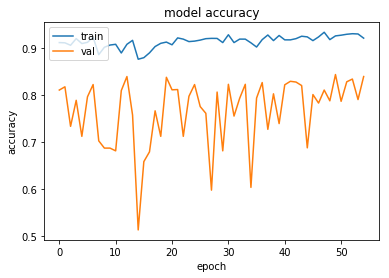

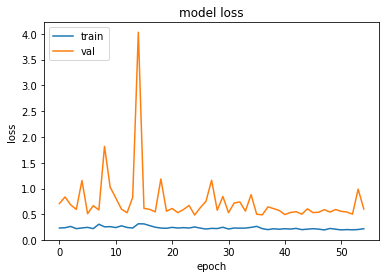

In [64]:
def display_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(save_dir+'accuracy_DenseNet21_1_acc.png')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(save_dir+'loss_DenseNet_121_1_loss.png')
    plt.show()
display_history(his)

In [65]:
model.evaluate_generator(valid_generator,verbose=1)

29/29 [==============================] - 29s 1s/step


[0.6028472920512746, 0.8386581570893938]

In [66]:
model.save(save_dir+'Stage_1_DenseNet121_binary_generator_1_final.h5')

In [60]:

'''
valid_generator = valid_datagen.flow_from_directory(
    directory=val_read_path,
    target_size=size,
    color_mode="rgb",
    batch_size=65,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
'''

check_generator = valid_datagen.flow_from_directory(
    directory=val_read_path,
    target_size=(size, size),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 1878 images belonging to 2 classes.


In [68]:
pred = model.predict_generator(valid_generator, verbose=1)
print (pred.shape)
labels = valid_generator.classes 
labels = np.array(labels)
print (labels.shape)
pred=np.argmax(pred,axis=1)



29/29 [==============================] - 29s 1s/step
(1878, 2)
(1878,)


In [69]:
print (pred[:20])
print (labels[:20])

[1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [70]:
valid_generator.class_indices

{'NG': 0, 'OK': 1}

In [71]:
import pandas as pd
pred_dict = {'pred':pred}
pred_df = pd.DataFrame(pred_dict)
pred_df['pred'].value_counts()

1    1070
0     808
Name: pred, dtype: int64

In [8]:
# gc.collect()

568

In [116]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    normalize=True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() +cm.min())/ 2.
    print (thresh)
    #thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [117]:
class_names = ['NG','OK']

[[410 527]
 [398 543]]
Normalized confusion matrix
0.5


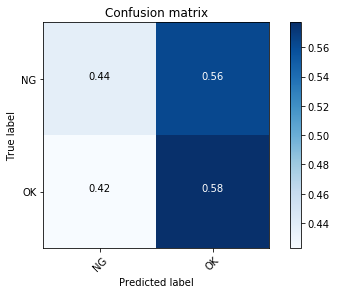

In [118]:
cnf_matrix = confusion_matrix(labels, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


In [119]:
from sklearn import metrics
print (metrics.classification_report(labels, pred))

             precision    recall  f1-score   support

          0       0.51      0.44      0.47       937
          1       0.51      0.58      0.54       941

avg / total       0.51      0.51      0.51      1878



In [121]:
import json
with open(save_dir+'history_DenseNet121.json', 'w') as f:
    json.dump(his.history, f)



In [18]:
with open (save_dir+'history_DEnseNet121.json','r') as f:
    his = json.load(f)

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


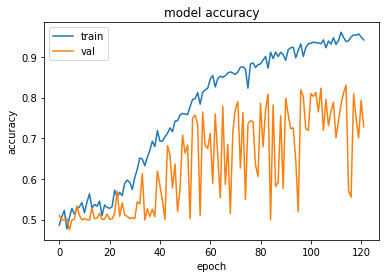

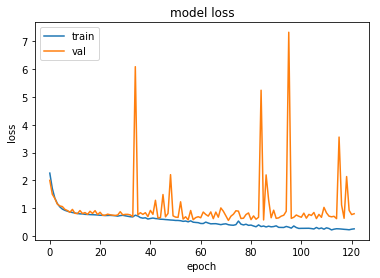

In [22]:
def display_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
display_history(his)

In [ ]:
def display_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('accuracy_2.png')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_2.png')
    plt.show()
display_history(his)